# EEG Source Reconstruction Pipeline

This script loads EEG epochs from an EEGLAB `.set` file, sets up a standard 64-channel montage, and computes the forward solution for source localization using the `fsaverage` template.


In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

## 1. Load EEG Epochs

We load preprocessed EEG data stored in an EEGLAB `.set` file and convert it to an MNE `Epochs` object for further processing.


In [2]:
raw_data_path = '../data/raw/'
path = raw_data_path + 'PPT1/'
input_fname = path + 's_101_Coordination.set'

In [3]:
epochs = mne.io.read_epochs_eeglab(input_fname)
print(epochs)

# Subsample the epochs to get a smaller dataset (optional)
epochs = epochs[:5]

Extracting parameters from /Users/s204684/Work/Special Course 2/Mirror_LEiDA/notebooks/../data/raw/PPT1/s_101_Coordination.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/3247319717.py:1: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(input_fname)
/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/3247319717.py:1: RuntimeWarning: Data file name in EEG.data (s_01_Coordination_AverageReref.fdt) is incorrect, the file name must have changed on disk, using the correct file name (s_101_Coordination.fdt).
  epochs = mne.io.read_epochs_eeglab(input_fname)


<EpochsEEGLAB | 87 events (all good), -1 – 4.996 s (baseline off), ~65.3 MiB, data loaded,
 '154/134/134': 32
 '134/114/154/134': 16
 '114/154/134/134': 24
 '134/154/134': 15>


## 2. Set Montage

We apply the standard 64-channel BioSemi montage to ensure correct electrode positioning in 3D space. This step is crucial for accurate source localization.


In [4]:
# set montage
montage = mne.channels.make_standard_montage('biosemi64')
epochs.set_montage(montage)

<EpochsEEGLAB | 5 events (all good), -1 – 4.996 s (baseline off), ~3.8 MiB, data loaded,
 '154/134/134': 2
 '134/114/154/134': 1
 '114/154/134/134': 1
 '134/154/134': 1>

## 3. Compute Forward Solution

The forward solution maps neural sources in the brain to EEG scalp signals. We use the `fsaverage` template, which includes:
- A predefined **source space** (dipole grid on the cortex).
- A **BEM model** (boundary element model of the head).
- A standard **head-to-MRI transform** (`fsaverage`).

The forward model is computed with `mne.make_forward_solution()`, ensuring sources are at least **5 mm** away from the inner skull.


In [5]:
SUBJECTS_DIR = mne.datasets.fetch_fsaverage()
SUBJECT = 'fsaverage'

if "fsaverage" in os.path.basename(SUBJECTS_DIR):
    SUBJECTS_DIR = os.path.dirname(SUBJECTS_DIR)  # Move one directory up
print(f"Fsaverage directory is at: {SUBJECTS_DIR}")

# Transformation file that aligns the EEG data with the MRI data
trans = 'fsaverage'  

# Source space that describes the locations of the dipoles
src = os.path.join(SUBJECTS_DIR, SUBJECT, 'bem', 'fsaverage-ico-5-src.fif') 

# Boundary Element Model that describes the volume conduction model
bem = os.path.join(SUBJECTS_DIR, SUBJECT, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif') 

0 files missing from root.txt in /Users/s204684/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage
Fsaverage directory is at: /Users/s204684/mne_data/MNE-fsaverage-data


In [6]:
# Build the forward solution
fwd = mne.make_forward_solution(
    info=epochs.info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    mindist=5.0,
    n_jobs=4
)

print(fwd)

# Save forward operator since it is the same for all subjects
source_path = '../data/source_reconstruction/'
fwd_fname = source_path + 'fsaverage_64_fwd.fif'
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

Source space          : /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/s204684/miniconda3/envs/mirror/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up th

/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/233809288.py:2: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 7445.7 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/233809288.py:2: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 9844.3 ms

Setting up for EEG...
Computing EEG at 20484 source locations (free orientations)...


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/233809288.py:2: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(



Finished.
<Forward | MEG channels: 0 | EEG channels: 64 | Source space: Surface with {self['nsource']} vertices | Source orientation: Free>
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


## 3.5 Load Forward solution


In [7]:
fname_fwd = source_path + 'fsaverage_64_fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from /Users/s204684/Work/Special Course 2/Mirror_LEiDA/notebooks/../data/source_reconstruction/fsaverage_64_fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (20484 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


## 4. Parcelation - Desikan-Killiany atlas
- 68 ROIs: 34 ROI from each hemisphere
- Named aparc.annot in MNE python fsaverage folder

In [8]:
labels = mne.read_labels_from_annot("fsaverage", parc="aparc",
                                    subjects_dir=SUBJECTS_DIR)
labels = labels[:-1] # remove unknowns

label_names = [label.name for label in labels]
print(label_names)

Reading labels from parcellation...
   read 35 labels from /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
['bankssts-lh', 'bankssts-rh', 'caudalanteriorcingulate-lh', 'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'entorhinal-lh', 'entorhinal-rh', 'frontalpole-lh', 'frontalpole-rh', 'fusiform-lh', 'fusiform-rh', 'inferiorparietal-lh', 'inferiorparietal-rh', 'inferiortemporal-lh', 'inferiortemporal-rh', 'insula-lh', 'insula-rh', 'isthmuscingulate-lh', 'isthmuscingulate-rh', 'lateraloccipital-lh', 'lateraloccipital-rh', 'lateralorbitofrontal-lh', 'lateralorbitofrontal-rh', 'lingual-lh', 'lingual-rh', 'medialorbitofrontal-lh', 'medialorbitofrontal-rh', 'middletemporal-lh', 'middletemporal-rh', 'paracentral-lh', 'paracentral-rh', 'parahippocampal-lh', 'parahippocampal-rh', 'parsopercularis-lh', 'parsopercula

# A. Simplest Source Reconstruction Pipeline

## 5. Compute Noise Covariance

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 21504
[done]
    The projection vectors do not apply to these channels.


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/1624229169.py:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epochs)


Computing rank from covariance with rank=None
    Using tolerance 7.3e-14 (2.2e-16 eps * 64 dim * 5.2  max singular value)
    Estimated rank (eeg): 52
    EEG: rank 52 computed from 64 data channels with 0 projectors


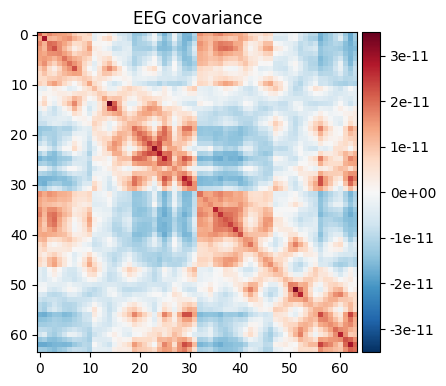

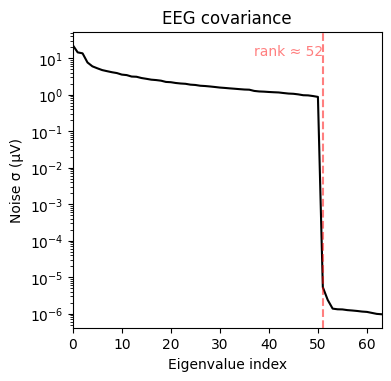

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [9]:
noise_cov = mne.compute_covariance(epochs)
noise_cov.plot(epochs.info, proj=True)


## 6. Create Inverse Operator

In [10]:
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info=epochs.info,
    forward=fwd,
    noise_cov=noise_cov,
    loose=1.0,
    depth=0.8,
    verbose=True
)

Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.329338
    scale = 108975 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 7.3e-14 (2.2e-16 eps * 64 dim * 5.2  max singular value)
    Estimated rank (eeg): 52
    EEG: rank 52 computed from 64 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/3321312679.py:1: RuntimeWarning: The largest eigenvalue of the 64-channel eeg covariance (rank=52) is over 10 orders of magnitude larger than the smallest (5.16e-10 > 1e10 * 2.79e-23), the resulting whitener will likely be unstable
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/3321312679.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_49156/3321312679.py:1: RuntimeWarning: The largest eigenvalue of the 64-channel eeg covariance (rank=52) is over 10 orders of magnitude larger than the smallest (5.16e-10 > 1e10 * 2.79e-23), the resulting whitener will likely be unstable
  inverse_op

    largest singular value = 7.2111
    scaling factor to adjust the trace = 1.21875e+29 (nchan = 64 nzero = 12)


## 7. Apply the Inverse to Epochs

In [11]:
epochs.set_eeg_reference(projection=True) # needed for inverse modelling, ignore error about filename due to selfmade info

snr = 3.0
lambda2 = 1.0 / snr**2
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs,
    inverse_operator,
    lambda2=lambda2,
    method='MNE',
    pick_ori='vector'
)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 52 (12 small eigenvalues omitted)
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 5
Processing epoch : 2 / 5
Processing epoch : 3 / 5
Processing epoch : 4 / 5
Processing epoch : 5 / 5
[done]


In [12]:
for stc in stcs:
    print(stc)
    print(stc.data.shape)

<VectorSourceEstimate | 20484 vertices, subject : fsaverage, tmin : -1000.0 (ms), tmax : 4996.09375 (ms), tstep : 3.90625 (ms), data shape : (20484, 3, 1536), ~720.3 MiB>
(20484, 3, 1536)
<VectorSourceEstimate | 20484 vertices, subject : fsaverage, tmin : -1000.0 (ms), tmax : 4996.09375 (ms), tstep : 3.90625 (ms), data shape : (20484, 3, 1536), ~720.3 MiB>
(20484, 3, 1536)
<VectorSourceEstimate | 20484 vertices, subject : fsaverage, tmin : -1000.0 (ms), tmax : 4996.09375 (ms), tstep : 3.90625 (ms), data shape : (20484, 3, 1536), ~720.3 MiB>
(20484, 3, 1536)
<VectorSourceEstimate | 20484 vertices, subject : fsaverage, tmin : -1000.0 (ms), tmax : 4996.09375 (ms), tstep : 3.90625 (ms), data shape : (20484, 3, 1536), ~720.3 MiB>
(20484, 3, 1536)
<VectorSourceEstimate | 20484 vertices, subject : fsaverage, tmin : -1000.0 (ms), tmax : 4996.09375 (ms), tstep : 3.90625 (ms), data shape : (20484, 3, 1536), ~720.3 MiB>
(20484, 3, 1536)


In [13]:
stc = stcs[1]
# Define plotting parameters
surfer_kwargs = dict(
    hemi="lh",
    subjects_dir=SUBJECTS_DIR,
)

# Plot surface
brain = stc.plot(**surfer_kwargs)

# Add title
brain.add_text(0.1, 0.9, "SourceEstimate", "title", font_size=16)

Using pyvistaqt 3d backend.
Using control points [2.33731094e-17 3.12712957e-17 1.61856845e-16]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


2025-02-14 19:30:22.589 python[49156:448818] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-14 19:30:22.589 python[49156:448818] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [14]:
stcs_label_ts = mne.extract_label_time_course(
    stcs, labels, fwd['src'], mode='mean')

print(f"Extracted label time courses for {len(stcs_label_ts)} epochs.")
print(f"Shape of the first epoch's ROI matrix: {stcs_label_ts[0].shape}")

Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracted label time courses for 5 epochs.
Shape of the first epoch's ROI matrix: (68, 3, 1536)


Shape of the first epoch's ROI matrix after dropping the direction dimension: (68, 1536)


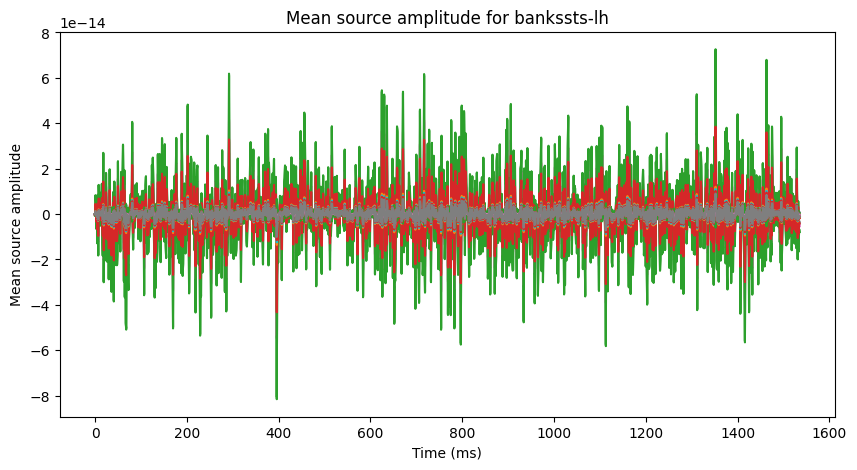

In [15]:
# Shape of the first epoch's ROI matrix: (68, 3, 1536)
# 68 labels, 3 directions, 1536 time points
# drop the direction dimension
stcs_label_ts = [np.mean(stc, axis=1) for stc in stcs_label_ts]
print(f"Shape of the first epoch's ROI matrix after dropping the direction dimension: {stcs_label_ts[0].shape}")

# plot the time series of the first label
plt.figure(figsize=(10, 5))
plt.plot(1e3 * stcs_label_ts[0].T)
plt.xlabel("Time (ms)")
plt.ylabel("Mean source amplitude")
plt.title(f"Mean source amplitude for {labels[0].name}")
plt.show()